In [1]:
#import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

from torch.utils.tensorboard import SummaryWriter


In [2]:
#import dataset
df = pd.read_csv('dataset-ml-25m/dataset.csv')

### Data Prepocessing

In [3]:
#split data and labels 
X = df.drop(['rating'], axis=1)
y = df['rating']

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)
#count the numebr of x_train 
print("Number of train set: ", X_train.shape[0])
print("Number of validation set: ", X_val.shape[0])
print("Numebr of test set: ", X_test.shape[0])

Number of train set:  9946
Number of validation set:  1106
Numebr of test set:  2764


In [4]:
# T-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=500)
X_train_tsne = tsne.fit_transform(X_train)


/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


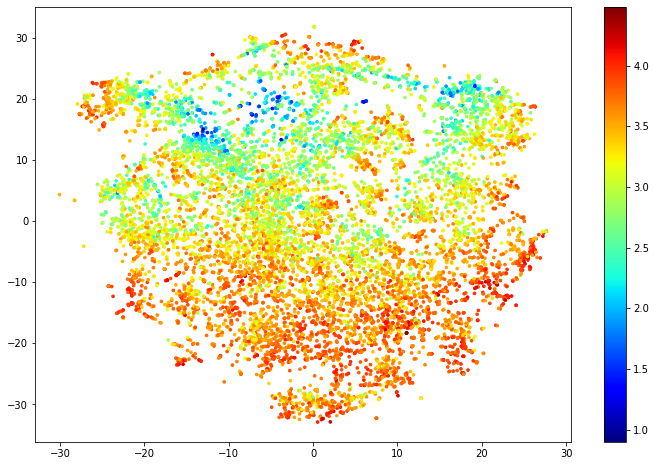

In [5]:
plt.figure(figsize=(12, 8))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap="jet", s=7)
plt.colorbar()

plt.show()

### Linear Regressor

In [6]:
log_name = f"linear_regression"
writer = SummaryWriter(f"results/tradML/no_pca/LinearRegression/{log_name}")

lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)
y_pred = lin_regr.predict(X_test)

# Compute the RSS
mse = mean_squared_error(y_test, y_pred) 
print('Mean Square Error:', mse)
writer.add_scalar('Loss', mse)
writer.flush()

# Compute the R-square index
rsquare = r2_score(y_test, y_pred) 
print('R-square:', rsquare)


Mean Square Error: 0.005445406919048585
R-square: 0.9754341910082424


### Random Forest Regressor
TEST SET
Mean Squared Error:  0.03662117019915541

R2 Score:  0.8361367494911226

iper con pca = 30 e quared_error
91 min


In [7]:
param_grid = {
                "n_estimators": [10, 15, 20, 25, 30],
                "criterion": ["squared_error", "friedman_mse"]
              }
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)
best_no_leaves= grid_search.best_params_
print("Best number of leaves: ", best_no_leaves)



Best number of leaves:  {'criterion': 'friedman_mse', 'n_estimators': 30}


In [10]:
display(grid_search.cv_results_)
#save into csv grid_search.cv_results_
pd.DataFrame(grid_search.cv_results_).to_csv("cv_results/no_pca/RandomForestRegressor.csv")

{'mean_fit_time': array([ 42.50552335,  64.18232226,  85.58802309, 106.58346972,
        128.61705036,  43.49080009,  65.27196288,  87.32491703,
        104.65559297, 119.29035439]),
 'std_fit_time': array([0.05504892, 0.12331654, 0.20542047, 0.38953163, 0.24507215,
        0.05791584, 0.20379228, 0.3160148 , 4.4311173 , 0.48518432]),
 'mean_score_time': array([0.02193522, 0.02677159, 0.03084593, 0.03593636, 0.04252729,
        0.02280378, 0.02778668, 0.03181281, 0.03403521, 0.03489966]),
 'std_score_time': array([0.00188291, 0.00113738, 0.00042286, 0.00137139, 0.00106894,
        0.00091996, 0.0019932 , 0.00058763, 0.00185822, 0.00103678]),
 'param_criterion': masked_array(data=['squared_error', 'squared_error', 'squared_error',
                    'squared_error', 'squared_error', 'friedman_mse',
                    'friedman_mse', 'friedman_mse', 'friedman_mse',
                    'friedman_mse'],
              mask=[False, False, False, False, False, False, False, False,
         

In [11]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_n_estimators', 'param_criterion', 'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

#save mse to tensorboard
writer = SummaryWriter(f"results/tradML/no_pca/RandomForest/")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    n_estimators = row['param_n_estimators']
    criterion = row['param_criterion']
    writer.add_hparams({"n_estimators": n_estimators, "criterion": criterion},{"hparam/mse": mse})
    writer.flush()
writer.close()

In [12]:
rf = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
rf = rf.T
rf.to_csv('best_params/no_pca/random_forest.csv', index=False)

In [13]:
rf = RandomForestRegressor(n_estimators = 30, criterion = "squared_error")
rf= rf.fit(X_train,y_train)

y_pred= rf.predict(X_test)
print ("TEST SET")
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))


TEST SET
Mean Squared Error:  0.012904347436823794
R2 Score:  0.9417847483192905


### Ridge Regressor
Mean Squared Error:  0.006422342939029505

R2 Score:  0.9712629065606324

In [14]:
param_grid = {
                "alpha":[0.0001, 0.001, 0.1, 0.5, 1, 5, 10, 20]
              }
ridge = Ridge()
ridge.fit(X_train,y_train)
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
#display(grid_search.cv_results_)
best_hyper= grid_search.best_params_
print("Best number of leaves: ", best_hyper)
#save into csv grid_search.cv_results_
pd.DataFrame(grid_search.cv_results_).to_csv("cv_results/no_pca/Ridge.csv")

Best number of leaves:  {'alpha': 5}


In [15]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_alpha','mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

#save mse to tensorboard
writer = SummaryWriter(f"results/tradML/no_pca/Ridge")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    alpha = row['param_alpha']
    writer.add_hparams({"alpha": alpha},{"/hparam/mse": mse})
    writer.flush()
writer.close()

In [16]:
ridge = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
ridge = ridge.T
ridge.to_csv('best_params/no_pca/ridge.csv', index=False)

In [17]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

print("TEST SET")
y_pred= ridge.predict(X_test)
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))


TEST SET
Mean Squared Error:  0.005434020515711962
R2 Score:  0.975485558374103


### KNN Regressor
Mean Squared Error:  0.04392172471123978

R2 Score:  0.8034700546159548

In [18]:
param_grid = {
                'n_neighbors': [3, 4, 5, 7, 8, 9, 10],
                'weights': ['uniform', 'distance']
              }
knn = KNeighborsRegressor()
knn.fit(X_train,y_train)
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
best_hyper= grid_search.best_params_
print("Best number of leaves: ", best_hyper)

Best number of leaves:  {'n_neighbors': 10, 'weights': 'distance'}


In [19]:
display(grid_search.cv_results_)
pd.DataFrame(grid_search.cv_results_).to_csv("cv_results/no_pca/KNN.csv")

{'mean_fit_time': array([0.0464026 , 0.0338294 , 0.03311944, 0.03171544, 0.03338518,
        0.03300982, 0.03339882, 0.03284359, 0.03111258, 0.03093538,
        0.03192873, 0.03286781, 0.03128729, 0.03131471]),
 'std_fit_time': array([0.02012899, 0.00100777, 0.00136702, 0.00075467, 0.00158918,
        0.001105  , 0.00191817, 0.00155071, 0.001158  , 0.00040545,
        0.00189638, 0.00114003, 0.0006677 , 0.00071249]),
 'mean_score_time': array([0.58713503, 0.54477115, 0.51359234, 0.55605893, 0.56225343,
        0.56428981, 0.58766432, 0.58194008, 0.55886278, 0.56050296,
        0.5510282 , 0.55120306, 0.55340781, 0.55321383]),
 'std_score_time': array([0.04123858, 0.01767736, 0.04658506, 0.02569679, 0.01647284,
        0.03157986, 0.02325304, 0.02773619, 0.01909691, 0.01869535,
        0.02297035, 0.01431599, 0.0211599 , 0.01977267]),
 'param_n_neighbors': masked_array(data=[3, 3, 4, 4, 5, 5, 7, 7, 8, 8, 9, 9, 10, 10],
              mask=[False, False, False, False, False, False, False,

In [20]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_n_neighbors', 'param_weights', 'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

#save mse to tensorboard
writer = SummaryWriter(f"results/tradML/no_pca/KNN/")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    n_neighbors = row['param_n_neighbors']
    weights = row['param_weights']
    writer.add_hparams({"n_neighbors": n_neighbors, "weights":weights},{"hparam/mse": mse})
    writer.flush()
writer.close()

In [21]:
knn = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
knn = knn.T
knn.to_csv('best_params/no_pca/knn.csv', index=False)

In [22]:
knn = KNeighborsRegressor(n_neighbors= 10, weights= 'distance')
knn.fit(X_train, y_train)

print("TEST SET")
y_pred= knn.predict(X_test)
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

TEST SET
Mean Squared Error:  0.040503488522491256
R2 Score:  0.8172770231251678


### Lasso Regressor

Mean Squared Error:  0.006402684362671739

R2 Score:  0.971350869839928

In [23]:
param_grid = {
                'alpha':[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
              }
lasso = Lasso()
lasso.fit(X_train,y_train)
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
best_hyper= grid_search.best_params_
print("Best values - Hyperparameters: ", best_hyper)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.527e+00, tolerance: 1.880e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.996e+00, tolerance: 1.910e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.742e+00, tolerance: 1.920e-01

Best values - Hyperparameters:  {'alpha': 1e-05}


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.046e+01, tolerance: 2.373e-01
  model = cd_fast.enet_coordinate_descent(


In [24]:
display(grid_search.cv_results_)
pd.DataFrame(grid_search.cv_results_).to_csv("cv_results/no_pca/Lasso.csv")

{'mean_fit_time': array([0.11197534, 0.37401876, 1.03203516, 5.63684168, 7.04571176,
        7.35400562]),
 'std_fit_time': array([0.00194667, 0.00547236, 0.03621484, 0.06079516, 0.03961796,
        0.07706427]),
 'mean_score_time': array([0.0114182 , 0.00942402, 0.00913849, 0.01053085, 0.00900331,
        0.0088057 ]),
 'std_score_time': array([0.0011321 , 0.00033688, 0.00081958, 0.00197874, 0.00148962,
        0.00074916]),
 'param_alpha': masked_array(data=[0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.1},
  {'alpha': 0.01},
  {'alpha': 0.001},
  {'alpha': 0.0001},
  {'alpha': 1e-05},
  {'alpha': 1e-06}],
 'split0_test_score': array([-0.24768672, -0.03424285, -0.01102863, -0.00587468, -0.00549774,
        -0.00555003]),
 'split1_test_score': array([-0.23264956, -0.03166397, -0.01007359, -0.00568045, -0.00549632,
        -0.00582371]),
 'split2_test_sc

In [25]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_alpha','mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

#save mse to tensorboard
writer = SummaryWriter(f"results/tradML/no_pca/Lasso/")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    alpha = row['param_alpha']
    writer.add_hparams({"alpha": alpha},{"hparam/mse": mse})
    writer.flush()
writer.close()

In [26]:
lasso = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
lasso= lasso.T
lasso.to_csv('best_params/no_pca/lasso.csv', index=False)

In [27]:
lasso = Lasso(alpha = 1e-05)
lasso.fit(X_train, y_train)

print("TEST SET")
y_pred= lasso.predict(X_test)
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

TEST SET
Mean Squared Error:  0.005423553353396875
R2 Score:  0.9755327787772686


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.046e+01, tolerance: 2.373e-01
  model = cd_fast.enet_coordinate_descent(


### SVR

Mean Squared Error:  0.0064680272514056085

R2 Score:  0.9710584898289305

51m

In [28]:
param_grid = {
                'kernel': ['linear', 'poly', 'rbf'],
                'epsilon': [0.001, 0.01, 0.1, 1]
              }
svr = SVR()
svr.fit(X_train,y_train)
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
best_hyper = grid_search.best_params_
print("Best values - Hyperparameters: ", best_hyper)

Best values - Hyperparameters:  {'epsilon': 0.001, 'kernel': 'rbf'}


In [29]:
display(grid_search.cv_results_)
pd.DataFrame(grid_search.cv_results_).to_csv("cv_results/no_pca/SVR.csv")

{'mean_fit_time': array([163.07262235,  81.87248578,  67.26869526, 141.41766558,
         56.36476359,  35.08845592,  39.54680986,  13.67070746,
          8.23262653,   0.26232657,   0.29980984,   0.34630017]),
 'std_fit_time': array([ 2.12298802,  0.85014081,  0.74420033,  2.22817858, 10.1173233 ,
         0.75664119,  1.42058449,  0.1510631 ,  0.15502645,  0.01069513,
         0.01936106,  0.02209247]),
 'mean_score_time': array([ 8.41809502,  8.44132514, 14.54251084,  7.52015333,  7.663627  ,
        12.77753806,  1.5830338 ,  2.86293635,  3.28553982,  0.03852234,
         0.04175758,  0.06532888]),
 'std_score_time': array([0.02371926, 0.02794658, 0.04529422, 0.01438484, 0.09312179,
        0.21703957, 0.00914112, 0.0712519 , 0.06860103, 0.00102054,
        0.00284822, 0.00430713]),
 'param_epsilon': masked_array(data=[0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1,
                    1, 1, 1],
              mask=[False, False, False, False, False, False, False, False,
     

In [30]:
#take only neg_mean_squared_error and convert to positive
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_kernel','param_epsilon' ,'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1


#save mse to tensorboard
writer = SummaryWriter(f"results/tradML/no_pca/SVR/")
for index, row in results.iterrows():
    mse = row['mean_test_score']
    kernel = row['param_kernel']
    epsilon = row['param_epsilon']
    writer.add_hparams({"kernel": kernel, "epsilon":epsilon},{"hparam/mse": mse})
    writer.flush()
writer.close()

In [31]:
svr = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
svr = svr.T
svr.to_csv('best_params/no_pca/svr.csv', index=False)

In [32]:
svr = SVR(kernel ='linear', epsilon = 0.01)
svr.fit(X_train, y_train)

print("TEST SET")
y_pred= svr.predict(X_test)
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

TEST SET
Mean Squared Error:  0.005522328373239375
R2 Score:  0.9750871760322983
